# Building A Portfolio

In [1198]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import ffn
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from scipy.stats import linregress

from matplotlib.ticker import  FuncFormatter


In [1199]:
#Getting 10 stocks for the Portfolio
start_date = '2019-06-03'
end_date = '2024-08-26'

stocks = ['CCJ', 'LMT', 'PANW','XOM', 'AMGN', 'AMAT', 'XOM', 'AMZN',  'JPM',] #Portfolio 

markets = ['^GSPC', 'QQQ',] #Markets

stocks_df = yf.download(stocks, start=start_date, end=end_date)['Adj Close'] #list of Adj Closing 

markets_df = yf.download(markets, start=start_date, end=end_date)['Adj Close'] 

Rfr = yf.download('^TNX', start=start_date, end=end_date)['Adj Close'] #Treasury Bill

[*********************100%%**********************]  8 of 8 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  1 of 1 completed


In [1200]:
stocks_df.aggregate([min, np.mean, np.median, np.std, max]).T #Statistics of the stock over the last 5 years

,min,mean,median,std,max
Ticker,,,,,
AMAT,36.455799,111.861011,112.989784,48.703507,254.482300
AMGN,147.112411,224.776003,218.756744,37.923252,333.646851
AMZN,81.820000,136.945257,142.220001,32.155332,200.000000
CCJ,5.421039,23.271433,22.130981,12.721315,55.509998
JPM,69.256454,130.423114,130.002792,31.595733,218.309998
LMT,246.577560,384.906553,368.554779,58.340268,563.219971
PANW,44.193333,163.296467,160.779999,80.276035,376.899994
XOM,25.236977,72.674844,62.460297,28.599906,120.247337


In [1201]:
markets_df.aggregate([min, np.mean, np.median, np.std, max]).T 

,min,mean,median,std,max
Ticker,,,,,
QQQ,164.431519,313.064180,313.086975,78.934672,502.959991
^GSPC,2237.399902,4012.479569,4090.750000,715.768560,5667.200195


<AxesSubplot: xlabel='Date'>

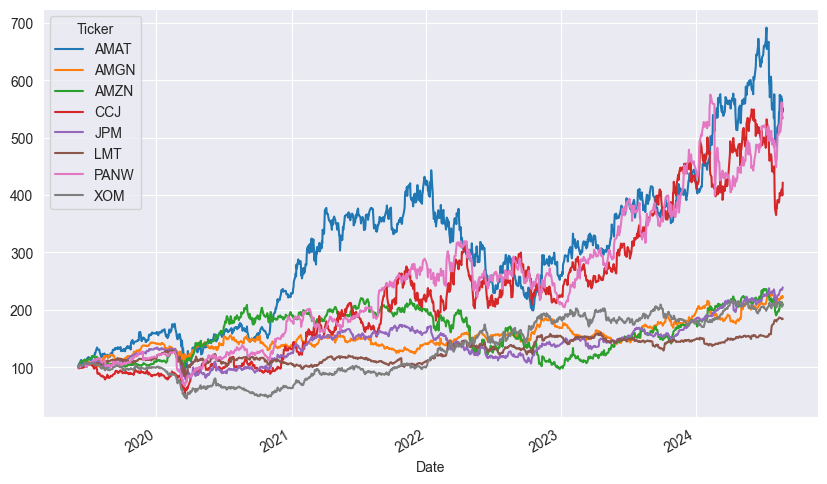

In [1202]:
#Normalize returns of the stocks
(stocks_df / stocks_df.iloc[0] * 100).plot(figsize=(10,6))

<AxesSubplot: xlabel='Date'>

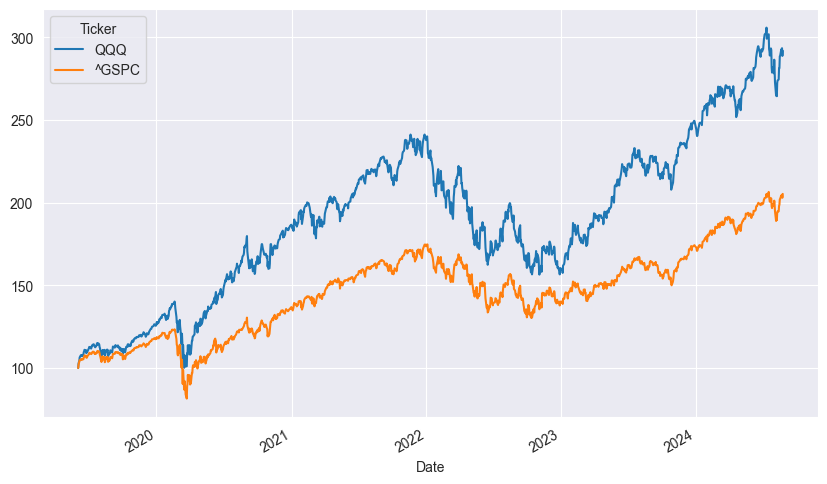

In [1203]:
#Normalize Returns of the Markets
(markets_df / markets_df.iloc[0]*100).plot(figsize=(10,6))

# Calculating Stock Returns

* Calculating 5 year return of the stock and the markets


In [1204]:
#Calculating Daily Returns
daily_returns = stocks_df.pct_change(1)

In [1205]:
#Drop nan values
daily_returns = daily_returns.dropna()

In [1206]:
daily_returns.isna().sum()

Ticker
AMAT    0
AMGN    0
AMZN    0
CCJ     0
JPM     0
LMT     0
PANW    0
XOM     0
dtype: int64

In [1207]:
#sum all the daily returns
returns_5yr = daily_returns.sum() * 100

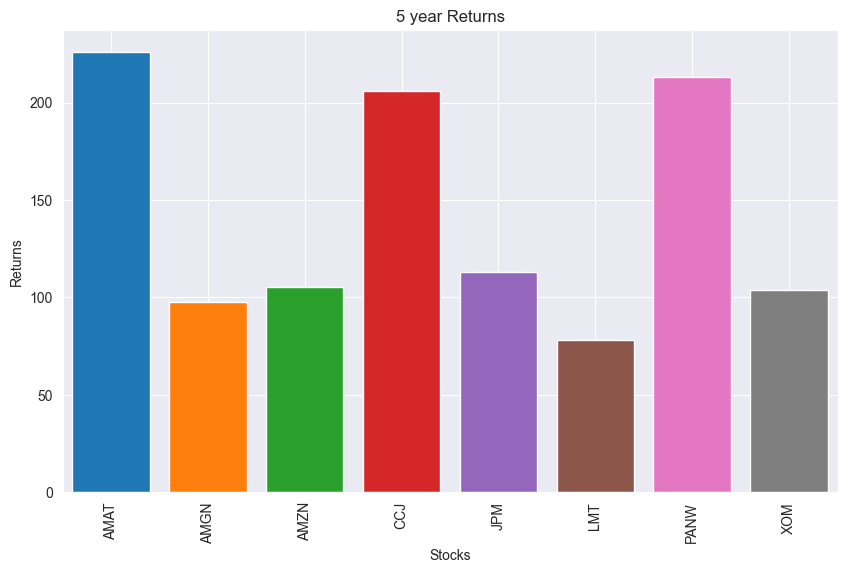

In [1208]:
#plot returns over 5 year period 
colors = plt.get_cmap('tab10')
returns_5yr.plot(kind='bar', figsize=(10,6))
plt.bar(returns_5yr.index, returns_5yr.values, color=colors(np.arange(len(returns_5yr))))
plt.title('5 year Returns')
plt.xlabel('Stocks')
plt.ylabel('Returns')
plt.show()

In [1209]:
#Calculating daily returns
markets_daily_returns = markets_df.pct_change(1)

In [1210]:
markets_daily_returns = markets_daily_returns.dropna()

In [1211]:
markets_daily_returns.isna().sum()

Ticker
QQQ      0
^GSPC    0
dtype: int64

In [1212]:
returns_5yr_markets = markets_daily_returns.sum() * 100

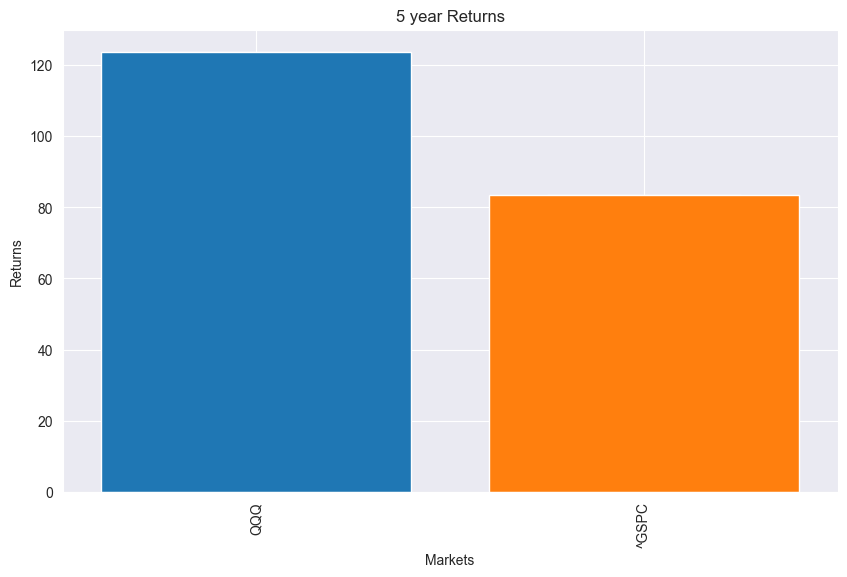

In [1213]:
#plot returns of the markets over 5-year period 
colors = plt.get_cmap('tab10')
returns_5yr_markets.plot(kind='bar', figsize=(10,6))
plt.bar(returns_5yr_markets.index, returns_5yr_markets.values, color=colors(np.arange(len(returns_5yr))))
plt.title('5 year Returns')
plt.xlabel('Markets')
plt.ylabel('Returns')
plt.show()

In [1214]:
daily_returns.shape

(1316, 8)

In [1215]:
markets_daily_returns.shape

(1316, 2)

# Expected Return

* Expected returns using CAPM
* Arbitrage Pricing Theory AP Models
* Arbitrage Pricing Theory APT using model suggest multiple factors affect returns

### CAPM Model
- Works on the premise that the return on any asset us based exclusively on the asset's relationship with the market

- Formula: Expected Return = rf+ Bj (E[rm] - rf) 
- Where: 
- E[rm] = Expected return on the stock market
- rf = Risk Free rate (e.g Yield of T-bills or T-Bonds)
- Bj = Systematic Risk (Market Risk) of stock j

In [1216]:
stocks_ß = []
tickers = []

market_variance = np.var(markets_daily_returns['^GSPC'])

for stock in daily_returns.columns: 
    covariance = np.cov(daily_returns[stock], markets_daily_returns['^GSPC'])[0,1]#[0,1] extract the covariance between the stock and the market, this then divided by the variance of the market
    
    beta = covariance / market_variance
    
    tickers.append(stock)
    stocks_ß.append(beta)

In [1217]:
beta_df = pd.DataFrame({'Ticker': tickers, 'Beta': stocks_ß })

In [1218]:
def daily_CAPM_model(daily_rfr, mr_daily, betas):
    #Convert annual risk-free rate into daily
    daily_rfr = (1 + Rfr.iloc[-1]) ** (1/250) - 1 
    
    #Calculate average daily returns 
    mr_daily = markets_daily_returns['^GSPC'].mean() 
    
    #Beta
    betas = beta_df['Beta']
    
    return daily_rfr + betas * (mr_daily - daily_rfr)

beta_df['Expected Daily Returns (CAPM)'] = daily_CAPM_model(daily_rfr, mr_daily, betas)

In [1246]:
def CAPM(Rfr, mr, betas):
    
    #Annual Market Return daily * 250
    mr = markets_daily_returns['^GSPC'].mean() * 250
    
    #Risk-free rate
    Rfr = Rfr[-1] / 100
    
    # Beta 
    betas = beta_df['Beta']
    
    return Rfr + betas * (mr - Rfr)    

beta_df['CAPM'] = CAPM(Rfr, mr, beta_df['Beta'])

In [1247]:
beta_df

,Ticker,Beta,Expected Daily Returns (CAPM),CAPM
0,AMAT,1.630571,-0.002938,0.234733
1,AMGN,0.634195,0.002707,0.114560
2,AMZN,1.071359,0.000230,0.167287
3,CCJ,0.972749,0.000789,0.155393
4,JPM,1.081771,0.000171,0.168543
5,LMT,0.592925,0.002941,0.109583
6,PANW,1.005878,0.000601,0.159389
7,XOM,0.853249,0.001466,0.140981


## 4 Factor Model
\[ E[r_j] = r_f + \beta_m (R_m - r_f) + \beta_s \text{SMB} + \beta_v \text{HML} + \beta_m \text{MOM} \] 

# STOP HERE 

In [1228]:
d = data[['AMAT', 'AMGN', 'AMZN', 'CCJ', 'LMT', 'LULU', 'PANW', 'XOM']] 

NameError: name 'data' is not defined

In [1229]:
stats = d.calc_stats()
stats.display()

NameError: name 'd' is not defined

In [1230]:
SOFI_stats = SOFI.calc_stats()
SOFI_stats.display()

NameError: name 'SOFI' is not defined

In [1231]:
PLTR_stats = PLTR.calc_stats()
PLTR_stats.display()

NameError: name 'PLTR' is not defined

In [1232]:
weights = np.array([0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10])

In [1233]:
#mean daily returns and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()

NameError: name 'returns' is not defined

In [1234]:
pf_return = np.sum(mean_daily_returns * weights) * 252
pr_return = round(pf_return, 3)

NameError: name 'mean_daily_returns' is not defined

In [1235]:
pf_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
pf_std_dev = round(pf_std_dev,3)

NameError: name 'cov_matrix' is not defined

In [1236]:
print('Expected annualized return: ' + '{:.1%}'.format(pf_return))
print("Volatility: " + "{:.1%}".format(pf_std_dev))

NameError: name 'pf_return' is not defined

In [1237]:
#calculate expected returns and sample covariance 
expected_returns = expected_returns.mean_historical_return(data)

NameError: name 'data' is not defined

In [1238]:
expected_returns

<module 'pypfopt.expected_returns' from '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pypfopt/expected_returns.py'>

In [1239]:
risk_model = risk_models.sample_cov(data)

NameError: name 'data' is not defined

In [1240]:
risk_model

NameError: name 'risk_model' is not defined

In [1241]:
#Optimize for maximal sharp ratio
ef = EfficientFrontier(expected_returns, risk_model)
raw_weight = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
perf = ef.portfolio_performance(verbose=True)

NameError: name 'risk_model' is not defined

In [1242]:
ef = EfficientFrontier(expected_returns, risk_model,  weight_bounds=(-1,1))
pf = ef.efficient_return(target_return=perf[0])
print(pf)
print()
perf = ef.portfolio_performance(verbose=True)

NameError: name 'risk_model' is not defined

In [1243]:
current_price = data.iloc[-1] #last price of the stock

NameError: name 'data' is not defined

In [1244]:
#cretate dictionary for the stock weights
w_data = {'AMZN': 0.10, 'CCJ': 0.10, 'LMT': 0.10, 'PLTR': 0.10, 'PANW': 0.10, 'LULU': 0.10, 'SOFI': 0.10, 'XOM': 0.10, 'AMGN': 0.10, 'AMAT': 0.10}

Using the Efficient Frontier for portfolio optimization can be limiting, as it tends to select the five stocks with the highest returns, making the portfolio less risk-averse

In [1245]:
da = DiscreteAllocation(w_data, current_price, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()
print('Discrete allocation:', allocation)
print('Funds remaining: ${:.2f}'.format(leftover))

NameError: name 'current_price' is not defined